# CSCI 381/780 (Fall 2023) - Project 1

**Due Date: Monday, October 2 by 4 PM**

## Description
In this project you will construct machine learning models on a dataset comprised of sociodemographic and financial data from a German bank. The machine learning task will be binary classification of people's creditworthiness for a bank loan.

## Instructions
1. In this project you will write code to construct machine learning models using various partitions (see the figure below) of the census dataset and write responses to questions concerning the performance of said models. Please complete all sections below, adding new *Code* or *Markdown* cells as appropriate to answer the questions.
2. There are many Scikit-learn functions that leverage randomness to generate results. For these functions, a pseudorandom generator can be initialized using a seed value by passing the parameter `random_state=XXX`, where `XXX` is some number between 1 and 2^31-1. For each of these functions, **you will utilize your CUNY ID number** to initialize the function. Functions include:
- `StratifiedShuffleSplit`
- `RandomForestClassifier`
- `RandomizedSearchCV`
- `mutual_info_classif`
3. You will **work independently** on the project. Please make use of the *Python Data Science Reference Materials* posted on Blackboard or *come to office hours* should you need further assistance.
4. You will submit a single Jupyter notebook containing all code and written responses via Blackboard by the due date listed above. 

<img src="project-1-data-folds.png" width="600" height="300">

## Grading

### Running Code
Your Jupyter notebook must be able to run from start to finish **without error**. Please turn any cell that contains scratch work or other non-executable items to *Raw*. **Notebooks that cannot run to completion will receive a grade of 0**.

### Holdout Set Evaluation
Your final models will be evaluated against a holdout set. You model performances with respect to AUC on this set must be *comparable* (e.g., within 5%) of those reported in Part 6.

### Rubric

|**Part**|0|1|2|3|4|5|6|7|**Total**|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**%**|20|10|10|15|10|10|15|10|100|


## Part 0: Load Data

Set the variable `CREDIT_FILE` to the **full path** to the credit dataset (**credit_dataset.xlsx**) on your system. Load the file into a dataframe, then:
1. Determine the number and types (*numeric*, *categorical*, *ordinal*) for each feature in the dataset.
2. Determine if there are any missing/null values for any features. 
3. Determine the number of classes and their prevalence in the dataset. Are the classes balanced?
4. The **features** of this must be encoded prior to being used to construct machine learning models. Create **three** encodings for the dataset:
  1. for any categorical variables, utilize an **ordinal** encoding.
  2. for any categorical variables, utilize a **one-hot** encoding.
  3. encode variables as **appropriate** - ordinal, one-hot, etc. For any ordinal variables, use an explicit ordering by using the `categories` argument for the `OrdinalEncoder` class in Scikit-learn.
5. The **labels** must be encoded prior to being used to construct machine learning models. Encode "good" as 1 (the *positive* class) and "bad" as 0 (the *negative* class). The technique in 4C above can be used.
6. Perform a **stratified split** of the data, **for each encoding from step 4**, into training/validation/test sets, 80%/10%/10%. 
7. Verify that the training/validation/test splits have the same prevalence as the original dataset.
8. Standardize **only numeric features** in the training/validation/test splits (fit on the training, then transform the validation/test sets). You may find the class `ColumnTransformer` useful for this task, but be mindful of the column reordering that results. Use the standardized splits for the SVM models *only*.

In [1]:
# 0.1

# pip install pandas
# pip install openpyxl
import pandas as pd
import numpy as np

CREDIT_FILE = "credit-dataset.xlsx"
dataframe = pd.read_excel(CREDIT_FILE)
# print(dataframe.head())

# access the data types
data_types = dataframe.dtypes
# print(data_types)

# result of manually sorting through features and identifying them properly
numeric_features = ['duration', 'loan-amount', 'age']
                                  
categorical_features = ['credit-history', 'loan-purpose', 'marital-status-sex', 'debtor-guarantor', 'property', 'other-debts', 'housing', 'employment-type', 'smartphone', 'foreign-status', 'dependents']

ordinal_features = ['checking-account', 'savings-account', 'employment-status', 'installment-rate', 'residency-duration', 'other-loans']

label = ['creditworthiness']

# manually list the ratings of the categorical / ordinal features from low to high where possible
ratings = {
    'checking-account': ['No checking account', 'Negative Balance', 'Less than 2000 EUR', 'More than 2000 EUR'],
    'credit-history': ['Has account in default', 'History of late payments', 'On-time payments until recently', 'On-time payments with this bank',
                       'On-time payments with all creditors'],
    'loan-purpose': ['Other', 'Re-training', 'Repairs', 'Business', 'Education', 'Electronics', 'Car (new)', 'Furniture/equipment', 'Car (used)', 'Domestic appliances'],
    'savings-account': ['No savings account', 'Less than 1000 EUR', 'Less than 5000 EUR', 'Less than 10000 EUR', 'More than 10000 EUR'],
    'employment-status': ['Unemployed', 'Same job < 1 year', 'Same job < 4 years', 'Same job < 7 years', 'Same job > 7 years'],
    'marital-status-sex': ['Male: divorced/separated', 'Male: married/widowed', 'Female: divorced/separated/married', 'Male: single'],
    'debtor-guarantor': ['Guarantor', 'Co-applicant', 'NaN'],
    'installment-rate': [1, 2, 3, 4],
    'residency-duration': [1,2,3,4],
    'other-loans':[1,2,3,4],
    'dependents':[1,2],
    'property': ['Unknown / no property', 'No real estate/pension, but owns vehicle', 'No real estate, but pension/life insurance', 'Real estate'],
    'other-debts': ['NaN', 'Store credit lines', 'Bank credit lines'],
    'housing': ['Rent', 'Subsidized/free housing', 'Own'],
    'employment-type': ['Unemployed/unskilled  - non-resident', 'Unskilled - resident', 'Manager/professional/sole proprietor', 'Skilled employee'],
    'smartphone': ['No', 'Yes'],
    'foreign-status': ['No', 'Yes'],
    'creditworthiness': ['Bad', 'Good']
}

In [2]:
# 0.1 / 0.2

# iterate through the columns to determine domain 
domain_dictionary = {}
nullable_features = []
for column in dataframe.columns:

    # column is just a string with the column name, I need to index the array with the column name
    # print(type(column))
    
    # type is series, so I can use series operations
    # print(type(dataframe[column]))

    # collect unique values of series object
    domain = dataframe[column].unique()
    
    # print(f"Column: {column}")
    # print(f"Domain: {domain}")

    # build dictionary for each where key is column and value is list of domain
    domain_dictionary[column] = domain

    # type is ndarray, so I can use ndarray operations
    # print(type(domain))
    
    # np.isnan does not work for objects, so use pd instead to convert each domain value to T (if nan) or F (if not nan)
    null_array = pd.isna(domain)

    # print(null_array)
    # check if any of the values are true, in which case nan is in the domain
    if True in null_array:
        nullable = True
        nullable_features.append(column)
    else:
        nullable = False
    # print(f"Nullable: {nullable}\n\n")

for feature in nullable_features:
    print(f"{feature} is nullable")

# debtor-guarantor is nullable
# other-debts is nullable

debtor-guarantor is nullable
other-debts is nullable


In [3]:
# 0.3

def find_prevalence(dataframe, column_name):

    # iterate through the column names
    column = dataframe[column_name]

    # get total number of classes using unique array size
    number_of_classes = len(dataframe[column_name].unique())

    # change default parameters to normalize (get as a decimal) and not dropna (keep nan class in percentages)
    class_percentages = dataframe[column_name].value_counts(normalize=True, dropna = False)
    
    print(f"Column: {column_name}")
    print(f"Number of Classes: {number_of_classes}\n")
    print(class_percentages)
    print("\n\n\n")

find_prevalence(dataframe, 'creditworthiness')

# the classes are clearly not balanced, with 70% good credit and 30% bad credit

Column: creditworthiness
Number of Classes: 2

creditworthiness
Good    0.7
Bad     0.3
Name: proportion, dtype: float64






In [4]:
# 0.4 / 0.5
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# 0.4.1

# function to return dataframe with all features passed in replaced with ordinal encodings
def ordinal_dataframe_maker(ordinal_features, dataframe_original):
    
    # make a deep copy of the dataframe, where features will be dropped and added
    results_dataframe = dataframe_original.copy(deep=True)
    
    for feature in ordinal_features:
        rankings = ratings[feature]
        feature_dataframe = pd.DataFrame(dataframe[feature].fillna('NaN'))

        # encode according to custom rankings
        enc = OrdinalEncoder(categories = [ratings[feature]], dtype=int)
        enc.fit(feature_dataframe)
        encoded_feature = enc.transform(feature_dataframe)
    
        # drop old column values, replace with new column
        results_dataframe = results_dataframe.drop(feature, axis = 1)
        results_dataframe[feature] = encoded_feature

    return results_dataframe

    
# group the label in with the ordinal in all cases, to take care of 0.5
results_dataframe_one = ordinal_dataframe_maker(ordinal_features + categorical_features + label, dataframe)

# 0.4.2
# function to return dataframe with all features passed in replaced with one-hot encodings
def onehot_dataframe_maker(categorical_features, dataframe_original):
    results_dataframe = dataframe_original.copy(deep=True)
    for feature in categorical_features:
        feature_dataframe = pd.DataFrame(dataframe[feature].fillna('NaN'))

        # encode according to custom rankings
        enc = OneHotEncoder(sparse_output=False, dtype=int)
        enc.fit(feature_dataframe)
        encoded_feature = enc.transform(feature_dataframe)
        encoded_dataframe = pd.DataFrame(data=encoded_feature, columns = enc.get_feature_names_out([feature]), index = feature_dataframe.index)
    
        # concat the dataframes and drop the old feature
        results_dataframe = results_dataframe.drop(feature, axis = 1)
        results_dataframe = pd.concat([results_dataframe, encoded_dataframe], axis = 1)

    return results_dataframe


results_dataframe_two = onehot_dataframe_maker(ordinal_features + categorical_features, dataframe)
# additional step to make the label ordinal
results_dataframe_two = ordinal_dataframe_maker(label, results_dataframe_two)
# print(results_dataframe_two)

# 0.4.3
# first ordinal encode the ordinal features
post_ordinal_dataframe = ordinal_dataframe_maker(ordinal_features + label, dataframe)

# then one-hot encode the categorical features
results_dataframe_three = onehot_dataframe_maker(categorical_features, post_ordinal_dataframe)

# 0.5 has already been taken care of by putting in '+ label' to ordinal encode it

In [5]:
# 0.6

from sklearn.model_selection import train_test_split

# first split the training into 0.8 and validation/test into 0.2, to then be split into 0.1 and 0.1
train_one, validation_test_one = train_test_split(results_dataframe_one, test_size = 0.2, random_state = 23907251, stratify = results_dataframe_one['creditworthiness'])
train_two, validation_test_two = train_test_split(results_dataframe_two, test_size = 0.2, random_state = 23907251, stratify = results_dataframe_two['creditworthiness'])
train_three, validation_test_three = train_test_split(results_dataframe_three, test_size = 0.2, random_state = 23907251, stratify = results_dataframe_three['creditworthiness'])

test_one, validation_one = train_test_split(validation_test_one, test_size = 0.5, random_state = 23907251, stratify = validation_test_one['creditworthiness'])
test_two, validation_two = train_test_split(validation_test_two, test_size = 0.5, random_state = 23907251, stratify = validation_test_two['creditworthiness'])
test_three, validation_three = train_test_split(validation_test_three, test_size = 0.5, random_state = 23907251, stratify = validation_test_three['creditworthiness'])

set_one = [train_one, validation_one, test_one]
set_two = [train_two, validation_two, test_two]
set_three = [train_three, validation_three, test_three]

In [6]:
# 0.7

for set_x in set_one + set_two + set_three:
    find_prevalence(set_x, 'creditworthiness')

# classes are balanced since they are positive = 0.7 and negative = 0.3 for all groups of data, which match each other and the original dataset

Column: creditworthiness
Number of Classes: 2

creditworthiness
1    0.7
0    0.3
Name: proportion, dtype: float64




Column: creditworthiness
Number of Classes: 2

creditworthiness
1    0.7
0    0.3
Name: proportion, dtype: float64




Column: creditworthiness
Number of Classes: 2

creditworthiness
1    0.7
0    0.3
Name: proportion, dtype: float64




Column: creditworthiness
Number of Classes: 2

creditworthiness
1    0.7
0    0.3
Name: proportion, dtype: float64




Column: creditworthiness
Number of Classes: 2

creditworthiness
1    0.7
0    0.3
Name: proportion, dtype: float64




Column: creditworthiness
Number of Classes: 2

creditworthiness
1    0.7
0    0.3
Name: proportion, dtype: float64




Column: creditworthiness
Number of Classes: 2

creditworthiness
1    0.7
0    0.3
Name: proportion, dtype: float64




Column: creditworthiness
Number of Classes: 2

creditworthiness
1    0.7
0    0.3
Name: proportion, dtype: float64




Column: creditworthiness
Number of Classes: 2

c

In [7]:
# 0.8
from sklearn.preprocessing import StandardScaler

# function to standardize a dataset
def standardize_maker(train, test, validation, numeric_features):
    scaler = StandardScaler()
    scaler = scaler.fit(train[numeric_features])
    
    standardize_train = train.copy(deep=True)
    standardize_train[numeric_features] = scaler.transform(standardize_train[numeric_features])

    scaler = scaler.fit(train[numeric_features])
    standardize_test = test.copy(deep=True)
    standardize_test[numeric_features] = scaler.transform(standardize_test[numeric_features])

    scaler = scaler.fit(train[numeric_features])
    standardize_validation = validation.copy(deep=True)
    standardize_validation[numeric_features] = scaler.transform(standardize_validation[numeric_features])

    

    return standardize_train, standardize_test, standardize_validation 

# create standardized datasets
st_train_one, st_test_one, st_validation_one = standardize_maker(train_one, test_one, validation_one, numeric_features)

# print(st_train_one)
# print(st_test_one)
# print(st_validation_one)

st_train_two, st_test_two, st_validation_two = standardize_maker(train_two, test_two, validation_two, numeric_features)

# print(st_train_two)
# print(st_test_two)
# print(st_validation_two)

st_train_three, st_test_three, st_validation_three = standardize_maker(train_three, test_three, validation_three, numeric_features)

training_validation_test_tuples = [
    (train_one, validation_one, test_one),
    (train_two, validation_two, test_two),
    (train_three, validation_three, test_three)
]

st_training_validation_test_tuples = [
    (st_train_one, st_validation_one, st_test_one),
    (st_train_two, st_validation_two, st_test_two),
    (st_train_three, st_validation_three, st_test_three)

]

## Part 1: Train Initial Models

Using default hyperparameters:
1. Construct **Naive Bayes (NB)**, **Support Vector Machine (SVM)** , and **Random Forest (RF)** models on the training sets for each encoding from step 4.
2. Calculate the confusion matrix and report the following performance metrics on the **training set**:
    *Accuracy*, *F1 Score*, *AUC*, *Sensitivity*, *Specificity*, *Precision*, and *NPV*. You can use the function `binary_metrics` for this purpose. Are any of the models underfitting the data? Is so, why?

3. Calculate the same metrics by applying the trained model to the **validation set**. Compare and contrast the errors each model makes in terms of each class.
4. Determine which dataset encoding yields the best performance on the **validation set**. Describe why you think this encoding performs the best. **Use only the best encoding for the remainder of the project**. 

In [8]:
#peformance metric functions
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import numpy as np

#A list of keys for the dictionary returned by binary_metrics
metric_keys = ['auc','f1','accuracy','sensitivity','specificity', 'precision', 'npv']

def binary_metrics(y_true,y_pred,include_cm=True):
    cm = confusion_matrix(y_true,y_pred,labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    
    #set AUC to NaN if all labels are of a single class
    if len(np.unique(y_true)) == 2:
        auc = roc_auc_score(y_true,y_pred) 
    else:
        auc = float('nan')

    #set F1 to NaN if all predictions are true negatives
    if (fp + fn +tp) >0:
        f1=f1_score(y_true,y_pred)
    else:
        f1 = float('nan')

    #set metrics to NaN if there are zero divisors
    sensitivity = tp/(tp+fn) if (tp+fn)!= 0 else float('nan')
    specificity = tn/(tn+fp) if (tn+fp)!= 0 else float('nan')
    precision = tp / (tp + fp) if (tp + fp) != 0 else float('nan')
    npv = tn/(tn+fn) if (tn+fn) !=0 else float('nan')

    if include_cm:
        return {
            'auc': auc,
            'f1': f1,
            'accuracy': (tp+tn)/np.sum(cm),
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'npv': npv,
            'confusion_matrix': cm}
    else:
        return {
            'auc': auc,
            'f1': f1,
            'accuracy': (tp+tn)/np.sum(cm),
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'npv': npv}

#This wrapper can be used to return multiple performance metrics during cross-validation
def binary_metrics_scorer(clf,X,y_true):
    y_pred=clf.predict(X)
    return binary_metrics(y_true,y_pred,include_cm=False)

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def results_printer(results):
    for x, y in results.items():
        print(f"{x}: {y}")

def model_implementation(model, train, validation, label_string = 'creditworthiness', return_full_results = False):

    # training features is the entire dataframe minus creditworthiness
    x_train = train.drop(columns=['creditworthiness'])

    # training labels are creditworthiness
    y_train = train['creditworthiness']

    # train the model on the training data
    model.fit(x_train, y_train)

    # testing data is validation data minus creditworthiness
    x_test = validation.drop(columns=['creditworthiness'])

    # true labels are creditworthiness
    y_true = validation['creditworthiness']

    # predict labels
    y_pred = model.predict(x_test)

    results = binary_metrics(y_true, y_pred)

    if return_full_results:
        return results, y_pred, y_true
    else:
        return results
    

max_result = 0
max_model = None
# I will choose the model that has the highest sum of F1 for all three, since I see no reason to give higher importance to either class and I want to balance the importance of false negatives and false positives
# I also see no reason to give higher importance to any one model

for index in range(len(training_validation_test_tuples)):

    train, validation, _ = training_validation_test_tuples[index]

    # naive bayes
    gnb = GaussianNB()

    print(f"NAIVE BAYES - Results of testing TRAIN data on model {index + 1}")
    results_printer(model_implementation(gnb, train, train))

    print(f"NAIVE BAYES - Results of testing VALIDATION data on model {index + 1}")
    gnb_results = model_implementation(gnb, train, validation)
    results_printer(gnb_results)

    print("\n\n\n")

    # random forest
    rf = RandomForestClassifier(random_state=23907251)

    print(f"RANDOM FOREST - Results of testing TRAIN data on model {index + 1}")
    results_printer(model_implementation(rf, train, train))

    print(f"RANDOM FOREST - Results of testing VALIDATION data on model {index + 1}")
    rf_results = model_implementation(rf, train, validation)
    results_printer(rf_results)

    print("\n\n\n")

    # random forest
    svm = SVC(random_state=23907251)

    # standardized data
    train, validation, _ = st_training_validation_test_tuples[index]

    print(f"SVM - Results of testing TRAIN data on model {index + 1}")
    results_printer(model_implementation(svm, train, train))

    print(f"SVM - Results of testing VALIDATION data on model {index + 1}")
    svm_results = model_implementation(svm, train, validation)
    results_printer(svm_results)

    if gnb_results['f1'] + rf_results['f1'] + svm_results['f1'] > max_result:
        max_result = gnb_results['f1'] + rf_results['f1'] + svm_results['f1']
        max_model = index + 1
    
    print("\n\n\n\n\n\n")

print(f"best encoding is: {max_model}")
max_train, max_validation, max_test = training_validation_test_tuples[max_model - 1]
max_st_train, max_st_validation, max_st_test = st_training_validation_test_tuples[max_model - 1]

NAIVE BAYES - Results of testing TRAIN data on model 1
auc: 0.6904761904761906
f1: 0.784037558685446
accuracy: 0.7125
sensitivity: 0.7455357142857143
specificity: 0.6354166666666666
precision: 0.8267326732673267
npv: 0.5169491525423728
confusion_matrix: [[122  70]
 [114 334]]
NAIVE BAYES - Results of testing VALIDATION data on model 1
auc: 0.5803571428571428
f1: 0.7652173913043477
accuracy: 0.6625
sensitivity: 0.7857142857142857
specificity: 0.375
precision: 0.7457627118644068
npv: 0.42857142857142855
confusion_matrix: [[ 9 15]
 [12 44]]




RANDOM FOREST - Results of testing TRAIN data on model 1
auc: 1.0
f1: 1.0
accuracy: 1.0
sensitivity: 1.0
specificity: 1.0
precision: 1.0
npv: 1.0
confusion_matrix: [[192   0]
 [  0 448]]
RANDOM FOREST - Results of testing VALIDATION data on model 1
auc: 0.6696428571428572
f1: 0.864
accuracy: 0.7875
sensitivity: 0.9642857142857143
specificity: 0.375
precision: 0.782608695652174
npv: 0.8181818181818182
confusion_matrix: [[ 9 15]
 [ 2 54]]




SVM - R

1.2 
Both GNB and SVM are underfitting the training data, while random forest is a perfect fit on the training data. 
I determined this by looking at the accuracy from the trial where 'train' was used as the testing data.

1.3
for this question I will just look at the top encoding, which is encoding 3

GNB is classifying too many samples as negative, causing it to have an equal number of missed positives and negatives. 
Its performance for positives is much stronger

RF performs extremely well on positive cases but is missing nearly as many negative cases as it is hitting


SVM is predicting nearly all cases as positive, resulting in solid performance 
but only because most of the test cases were positive

1.4
Encoding 3 is the best, which makes sense because it correctly treats ordinal features as ranked features and 
for categorical features, it breaks them down into one-hot features, not giving additional meaning to the arbitrary
ordering of the categories within a feature.

Part 2: Cross-Validation Models

Split the **non-test data** (*training* + *validation* data) into **stratified 5-folds** for cross-validation purposes, then:
1. Train NB, SVM, and RF models using 5-fold cross-validation.
2. Report the mean and standard deviation of the performance metrics listed in Part 1.2 for each model. You may use the function `collate_cv_results` for this purpose.
3. How does the performance of these models compare with those created in Part 1? Which models' performances are more consistent, and why?

In [10]:
#Summarizes model performance results produced during cross-validation
def collate_cv_results(cv_results,display=True):
    cv_stats=dict()
    for k in cv_results:
        cv_stats[k+"_mean"]=np.mean(cv_results[k])
        cv_stats[k+"_std"]=np.std(cv_results[k])
        if display:
            print(k,cv_stats[k+"_mean"],"("+str(cv_stats[k+"_std"])+")")
    return cv_stats

In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# result coming out of binary_metrics not matching what collate wants in, so modify results helper function is needed
def modify_results(results):
    keys = results[0].keys()
    results_dict = {}
    for key in keys:
        result_list = []
        for result in results:
            result_list.append(result[key])
        results_dict[key] = result_list
    return results_dict


# initialize models
gnb = GaussianNB()
rf = RandomForestClassifier(random_state=23907251)
svm = SVC(random_state=23907251)

# initialize results
gnb_results = []
rf_results = []
svm_results = []

# concat on axis 0 because that means you're adding all the rows to make more rows rather than adding columns to each row
max_train_validation = pd.concat([max_train, max_validation], axis = 0)
max_st_train_validation = pd.concat([max_st_train, max_st_validation], axis = 0)

max_x = max_train_validation.drop(columns=['creditworthiness'])
max_y = max_train_validation['creditworthiness']

max_st_x = max_st_train_validation.drop(columns=['creditworthiness'])
max_st_y = max_st_train_validation['creditworthiness']

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 23907251)

for i, (train_index, test_index) in enumerate(skf.split(max_x, max_y)):
    x_train_fold, x_validation_fold = max_x.iloc[train_index], max_x.iloc[test_index]
    y_train_fold, y_validation_fold = max_y.iloc[train_index], max_y.iloc[test_index]

    gnb.fit(x_train_fold, y_train_fold)
    y_pred = gnb.predict(x_validation_fold)
    gnb_results.append(binary_metrics(y_validation_fold, y_pred))

    rf.fit(x_train_fold, y_train_fold)
    y_pred = rf.predict(x_validation_fold)
    rf_results.append(binary_metrics(y_validation_fold, y_pred))

for i, (train_index, test_index) in enumerate(skf.split(max_st_x, max_st_y)):
    x_train_fold, x_validation_fold = max_st_x.iloc[train_index], max_st_x.iloc[test_index]
    y_train_fold, y_validation_fold = max_st_y.iloc[train_index], max_st_y.iloc[test_index]

    svm.fit(x_train_fold, y_train_fold)
    y_pred = svm.predict(x_validation_fold)
    svm_results.append(binary_metrics(y_validation_fold, y_pred))

# for ind_result in gnb_results:
#     print(ind_result)

# print('\n\n')

# for ind_result in rf_results:
#     print(ind_result)

# print('\n\n')

# for ind_result in svm_results:
#     print(ind_result)

print("Results printed in format '_metric_ _mean_ (_std_)'")
print("GNB")
gnb_cross_results = collate_cv_results(modify_results(gnb_results))

print("\n\n\nRF")
collate_cv_results(modify_results(rf_results))

print("\n\n\nSVM")
collate_cv_results(modify_results(svm_results))
# skf_results = model_implementation(skf, max_train, max_validation)
# results_printer(skf_results)

Results printed in format '_metric_ _mean_ (_std_)'
GNB
auc 0.662752956691018 (0.021562103505433913)
f1 0.7566299039496445 (0.02814373735774464)
accuracy 0.6819444444444445 (0.02685983278585237)
sensitivity 0.7101782178217821 (0.05309731786257749)
specificity 0.6153276955602538 (0.061877168087743364)
precision 0.8126433641265102 (0.017719816182683843)
npv 0.4799072391046483 (0.03624410054376815)
confusion_matrix 36.0 (21.515110968805157)



RF
auc 0.6199032298578695 (0.0268090956285695)
f1 0.8320726512134448 (0.018161448595649443)
accuracy 0.7402777777777778 (0.02507704178509414)
sensitivity 0.9206732673267325 (0.03479824916974808)
specificity 0.3191331923890063 (0.047028171498953636)
precision 0.7594565765213857 (0.011468464640527788)
npv 0.6452336929621314 (0.09521874885831415)
confusion_matrix 36.0 (33.83341543503996)



SVM
auc 0.55961852929479 (0.012141784439214232)
f1 0.829624427210978 (0.00563625958108378)
accuracy 0.7222222222222222 (0.008784104611578835)
sensitivity 0.96627722

{'auc_mean': 0.55961852929479,
 'auc_std': 0.012141784439214232,
 'f1_mean': 0.829624427210978,
 'f1_std': 0.00563625958108378,
 'accuracy_mean': 0.7222222222222222,
 'accuracy_std': 0.008784104611578835,
 'sensitivity_mean': 0.9662772277227722,
 'sensitivity_std': 0.01341335331862506,
 'specificity_mean': 0.15295983086680762,
 'specificity_std': 0.03218047898840332,
 'precision_mean': 0.726969043927818,
 'precision_std': 0.00795660782582813,
 'npv_mean': 0.6695665445665446,
 'npv_std': 0.06567650253754502,
 'confusion_matrix_mean': 36.0,
 'confusion_matrix_std': 37.76771107705628}

2.3
For GNB, the auc, accuracy, and f1 are all within 2 STD so I would not draw any significant conclusions,
although it should be noted the model in part 1 performed better

For RF, all three metrics were >2 STD higher, so the model in part 1 is performing better than the one in part 2

For SVM, auc, accuracy, and f1 are all right on the edge of 2 STD, with the model in part 2 performing better 
than the model in part 1

The SVM models are significantly more consistent than the GNB and RF models, with a much smaller STD on f1 and accuracy
I believe this is the case because it is classifying almost all cases as positive
therefore, the biggest performance difference is the % of positive cases which is not varying much (as expected) between folds

Part 3: SVM Hyperparameter Tuning

Utilizing the cross-validation dataset from Part 2, you will construct SVM models using the below strategies:
1. Using `RandomizedSearchCV`, determine the best choice of hyperparameters after **30 trials**  using the following possible values:
- *Kernel type*: Linear, polynomial, radial basis function
- *Degree (will used by the polynomial kernel only)*: `[2,8]` inclusive.
- *Box constraint (C)*: `loguniform(1e-3, 1e3)`
- *Kernel width (gamma)*: `loguniform(1e-3, 1e3)`
2. Report the time required to perform cross-validation via `RandomizedSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters. You may use the function `collate_ht_results` for this purpose.
3. Compare the performance of this model to the best SVM model constructed in Part 2. Which performs better?

### Please Read!
**For this part you will need to import the `loguniform` module from Scipy: ``from scipy.stats import loguniform``.**

There are a few parameters for the `RandomizedSearchCV` function that should be set:
- `scoring` - This controls the strategy to evaluate the performance of the cross-validated model on the test set, set it to `binary_metrics_scorer`.
- `refit` - This will refit an estimator using the best found parameters on the whole dataset, set it to `"auc"`
- `cv` - This will enable you to reuse your CV splits from Part 2.
    `n_jobs` - Number of jobs to run in parallel, if you have more than one core on your device (you should), set this to as many as you'd like to use, or to `-1` if you want to use all available cores.
- `return_train_score` - Setting this to `False` will reduce computational time.

In [12]:
#Summarizes model performance results produced during hyperparameter tuning
def collate_ht_results(ht_results,metric_keys=metric_keys,display=True):
    ht_stats=dict()
    for metric in metric_keys:
        ht_stats[metric+"_mean"] = ht_results.cv_results_["mean_test_"+metric][ht_results.best_index_]
        ht_stats[metric+"_std"] = metric_std = ht_results.cv_results_["std_test_"+metric][ht_results.best_index_]
        if display:
            print("test_"+metric,ht_stats[metric+"_mean"],"("+str(ht_stats[metric+"_std"])+")")
    return ht_stats

In [13]:
def binary_metrics_scorer_auc(clf,X,y_true):
    y_pred=clf.predict(X)
    return binary_metrics(y_true,y_pred,include_cm=False)['auc']

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import time



hyper_param_space = {
    'kernel' : ['linear', 'poly', 'rbf'],
    'degree' : [2,3,4,5,6,7,8],
    'C' : loguniform(1e-3, 1e3),
    'gamma' : loguniform(1e-3, 1e3)
}

svm = SVC()

hyper_search = RandomizedSearchCV(
    estimator = svm,
    param_distributions = hyper_param_space,
    n_iter = 30,
    refit = 'auc',
    cv = skf,
    n_jobs = -1,
    random_state = 23907251,
    scoring = binary_metrics_scorer,
    return_train_score = False
)

start_time = time.time()

hyper_search.fit(max_st_x, max_st_y)

end_time = time.time()

print(f"Time to perform cross-validation: {end_time - start_time}")

# print(hyper_search.cv_results_)

print("\n\n\nResults printed in format '_metric_ _mean_ (_std_)'")

print(f"Highest scoring hyperparams: {hyper_search.best_params_} with score: {hyper_search.best_score_}")

svm_cross_results = collate_ht_results(hyper_search)

Time to perform cross-validation: 6.1540868282318115



Results printed in format '_metric_ _mean_ (_std_)'
Highest scoring hyperparams: {'C': 48.815150367055594, 'degree': 3, 'gamma': 0.0212277480370364, 'kernel': 'poly'} with score: 0.6524070918719779
test_auc 0.6524070918719779 (0.030567249461583464)
test_f1 0.7987015879983778 (0.024982757806248732)
test_accuracy 0.7152777777777777 (0.030429030972509218)
test_sensitivity 0.8094653465346535 (0.044294227948414706)
test_specificity 0.49534883720930234 (0.05956394639472419)
test_precision 0.7894250276518318 (0.018809937662689676)
test_npv 0.5320008596604342 (0.05929544065938334)


C:\381D\project 1\381dproj1\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.52966579 0.74666667        nan 0.52664159 0.44913297        nan
        nan 0.49236379 0.52966579 0.5205251  0.4765738  0.53200086
 0.65       0.52988826 0.52988826 0.5029169         nan        nan
        nan 0.49256585 0.49256585 0.60423128        nan 0.52966579
 0.50993339        nan 0.52321417        nan 0.52966579        nan]
  warnings.warn(


3.3

This model performs better with a higher auc
This makes sense because in this case, we are running the same k-folds while searching through the hyperparameter space
Since there are 30 random hyperparameter selections, 
it makes sense that the best one will perform better than the best when we are only looking 
at one set of hyperparameter values (the default)

Part 4: Random Forest Hyperparameter Tuning

Utilizing the cross-validation dataset from Part 2, construct a Random Forest model:

1. Using `RandomizedSearchCV`, determine the best choice of hyperparameters after **30 trials** using the following possible values:
- *Split criterion*: Gini impurity, information gain (entropy)
- *Maximum tree depth*:None, log<sub>2</sub>|cross-validation dataset|-1 (use `ceil` to round up to the nearest integer)
- *Number of trees*: [10,20,...,100]
2. Report the time required to perform cross-validation via `RandomizedSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters. You may use the function `collate_ht_results` for this purpose.
3. Compare the performance of this model to the best RF model constructed in Part 2. Which performs better?

In [15]:
hyper_param_space = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, int(np.ceil(np.log2(len(max_x))))],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

rf = RandomForestClassifier(random_state = 23907251)

rf_hyper_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = hyper_param_space,
    n_iter = 30,
    refit = 'auc',
    cv = skf,
    n_jobs = -1,
    random_state = 23907251,
    scoring = binary_metrics_scorer,
    return_train_score = False
)

start_time = time.time()

rf_hyper_search.fit(max_x, max_y)

end_time = time.time()

print(f"Time to perform cross-validation: {end_time - start_time}")

print("\n\n\nResults printed in format '_metric_ _mean_ (_std_)'")

print(f"Best hyperparameters: {rf_hyper_search.best_params_} with score: {rf_hyper_search.best_score_}")

rf_cross_results = collate_ht_results(rf_hyper_search)

Time to perform cross-validation: 0.9591014385223389



Results printed in format '_metric_ _mean_ (_std_)'
Best hyperparameters: {'n_estimators': 40, 'max_depth': None, 'criterion': 'entropy'} with score: 0.6869024553618152
test_auc 0.6869024553618152 (0.04887973215787658)
test_f1 0.8547417936725068 (0.017848335488763942)
test_accuracy 0.7805555555555556 (0.030301978096210304)
test_sensitivity 0.9206336633663366 (0.01980451468928807)
test_specificity 0.45317124735729386 (0.0982936631800702)
test_precision 0.7982784701671262 (0.02747767620500298)
test_npv 0.7064504974990908 (0.06917405882110003)


4.3

Interestingly, though I expected similar results as part 3, 
the best performing model in part 2 beat this model out in both auc and accuracy

## Part 5: Feature Selection

Perform a stratified split of the **training data** into feature selection (1/8)/training (7/8) sets, then:
1. Calculate feature importance on the feature selection subset via *Mutual Information (MI)*. Produce a bar graph showing each feature's importance and its standard deviation, as determined by MI, in descending order. Be sure to set the `random-state` keyword argument for the mutual information function `mutual_info_classif`.
2. Choosing the **top 12 features**, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.
3. Choosing the **top 20 features**, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.
4. Compare the performance of the models with respect to the algorithm used (e.g., NB) and the number of features chosen (12, 20, and all features (those constructed in Part 1). How do they compare?

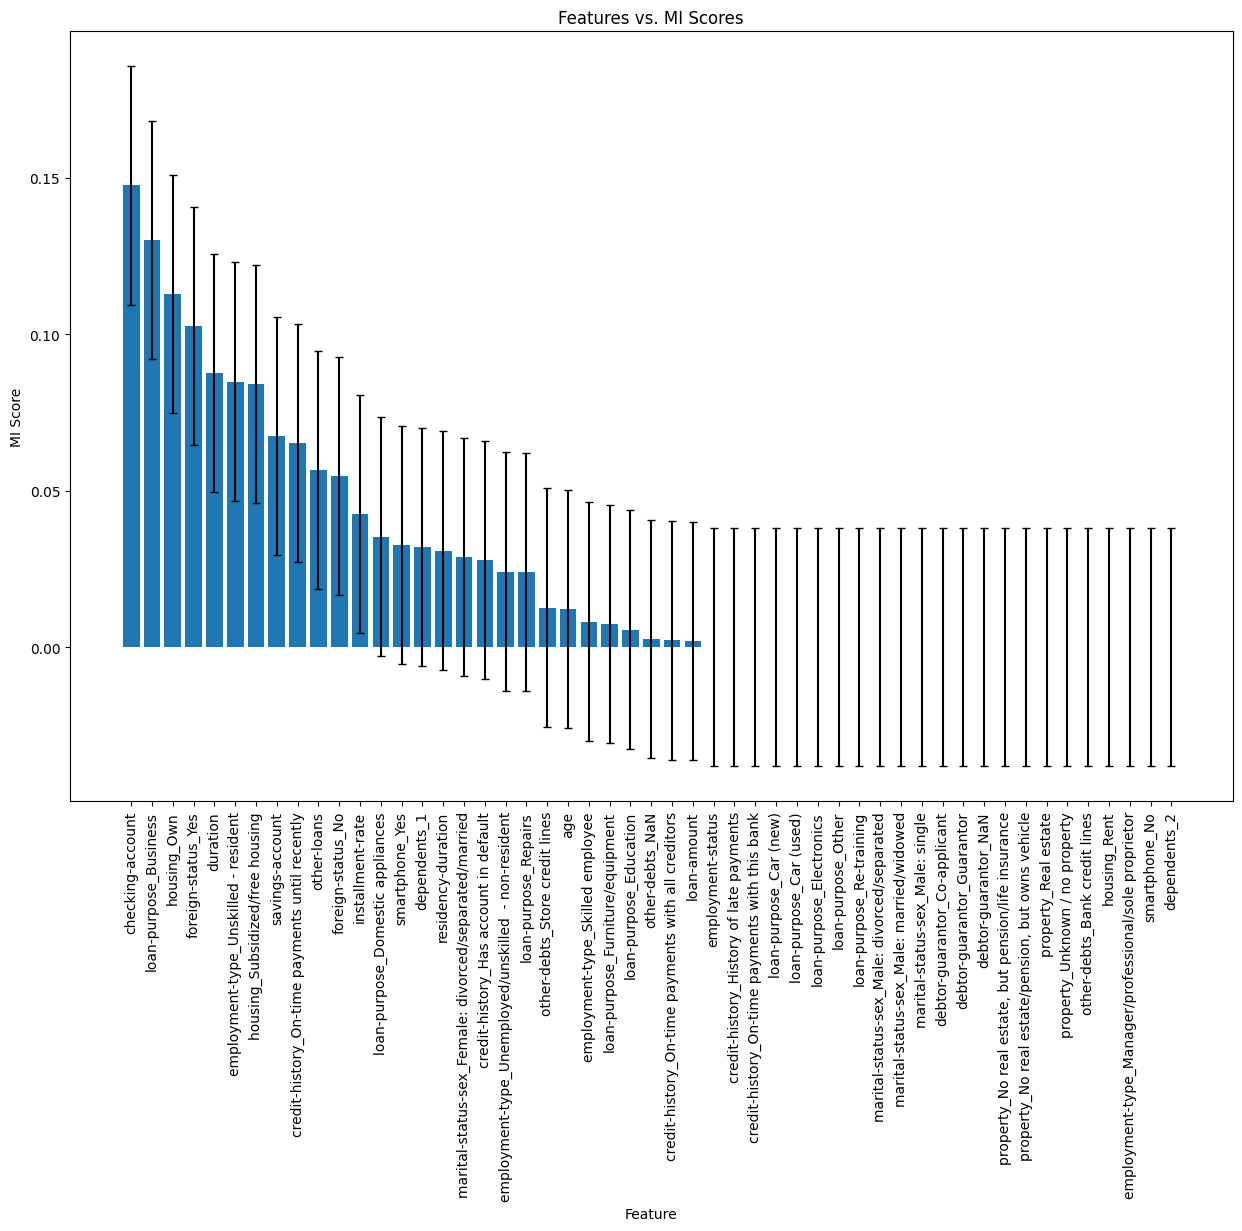

In [16]:
# 5.1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.model_selection import StratifiedShuffleSplit

feature_max_x = max_x.copy(deep = True)
feature_max_y = max_y.copy(deep = True)

# axis = 1 because we are adding columns rather than rows
feature_max = pd.concat([feature_max_x, feature_max_y], axis = 1)

feature_train, train = train_test_split(feature_max, test_size = 7/8, random_state = 23907251, stratify = feature_max_y)

mi_scores = mutual_info_classif(feature_train.drop(columns=['creditworthiness']), feature_train['creditworthiness'], random_state=23907251)

# print(mi_scores)

columns = feature_train.drop(columns=['creditworthiness']).columns

mi_dict = dict(zip(columns, mi_scores))

mi_column_tuples = []
for column, score in mi_dict.items():
    mi_column_tuples.append((column, score))

sorted_mi_column_tuples = sorted(mi_column_tuples, key = lambda x : x[1], reverse = True)

sorted_columns = [x[0] for x in sorted_mi_column_tuples]
sorted_mi_scores = [x[1] for x in sorted_mi_column_tuples]

plt.figure(figsize = (15,10))
plt.bar(sorted_columns, sorted_mi_scores, yerr = np.std(mi_scores), capsize = 3)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('MI Score')
plt.title('Features vs. MI Scores')
plt.show()

In [17]:
# 5.2 / 5.3 / 5.4

top_12_features = sorted_columns[:12]
top_20_features = sorted_columns[:20]

gnb = GaussianNB()
rf = RandomForestClassifier(random_state=23907251)
svm = SVC(random_state=23907251)

def train_on_n_features(train, validation, test, top_n_features):
    
    train_n = train[top_n_features + ['creditworthiness']]
    validation_n = validation[top_n_features + ['creditworthiness']]
    test_n = test[top_n_features + ['creditworthiness']]
    
    gnb_results = model_implementation(gnb, train_n, validation_n)

    rf_results = model_implementation(rf, train_n, validation_n)
    
    st_train, st_test, st_validation = standardize_maker(train, test, validation, numeric_features)

    st_train_n = st_train[top_n_features + ['creditworthiness']]
    st_validation_n = st_train[top_n_features + ['creditworthiness']]

    svm_results = model_implementation(svm, st_train_n, st_validation_n)

    return gnb_results, rf_results, svm_results

total_gnb_results, total_rf_results, total_svm_results = train_on_n_features(train, max_validation, max_test, top_12_features)

print("n = 12, GNB")
results_printer(total_gnb_results)

print("\n\n\nn = 12, RF")
results_printer(total_rf_results)

print("\n\n\nn = 12, SVM")
results_printer(total_svm_results)
    
total_gnb_results, total_rf_results, total_svm_results = train_on_n_features(train, max_validation, max_test, top_20_features)

print("\n\n\n\n\n\nn = 20, GNB")
results_printer(total_gnb_results)

print("\n\n\nn = 20, RF")
results_printer(total_rf_results)

print("\n\n\nn = 20, SVM")
results_printer(total_svm_results)

n = 12, GNB
auc: 0.7142857142857143
f1: 0.6888888888888888
accuracy: 0.65
sensitivity: 0.5535714285714286
specificity: 0.875
precision: 0.9117647058823529
npv: 0.45652173913043476
confusion_matrix: [[21  3]
 [25 31]]



n = 12, RF
auc: 0.8869047619047619
f1: 0.9482758620689654
accuracy: 0.925
sensitivity: 0.9821428571428571
specificity: 0.7916666666666666
precision: 0.9166666666666666
npv: 0.95
confusion_matrix: [[19  5]
 [ 1 55]]



n = 12, SVM
auc: 0.5793650793650794
f1: 0.8364348677766894
accuracy: 0.734920634920635
sensitivity: 0.9682539682539683
specificity: 0.19047619047619047
precision: 0.7362068965517241
npv: 0.72
confusion_matrix: [[ 36 153]
 [ 14 427]]






n = 20, GNB
auc: 0.7172619047619047
f1: 0.7422680412371134
accuracy: 0.6875
sensitivity: 0.6428571428571429
specificity: 0.7916666666666666
precision: 0.8780487804878049
npv: 0.48717948717948717
confusion_matrix: [[19  5]
 [20 36]]



n = 20, RF
auc: 0.9285714285714286
f1: 0.9649122807017544
accuracy: 0.95
sensitivity: 0.

5.4

the GNB results for n = 12 and n = 20 are strangely identical - 
I don't know why this is the case, I probably made an error somewhere but I can't
seem to find it
in either case, these results are significantly worse than the GNB result with all of the features

the RF results for n = 12 and n = 20 were extremely similar, and both significantly worse than the result with all of the features

the SVM results were similar for n = 12 and n = 20 (with 20 being better than 12)
with the results being significantly better than the model that used all of the features

it seems that for SVM limiting the features helped, but for GNB and RF it hindered


## Part 6: Final Models and Visualization

1. Using the full training set (**feature selection + training + validation**), train NB, SVM, and RF models, then apply them to the test set. Your final NB, SVM, and RF models should be named `gnb_final`, `svm_final`, and `rf_final`.
2. Create a bar chart of mean metrics from cross-validation, with standard deviation as an error bar for each model on the same plot. Use the NB model from Part 2, but the optimal models from Parts 3 and 4 for SVM and RF respectively.
3. Plot Receiver Operating Characteristic (ROC) curves for each final model in a single plot.
4. Which of the above metrics best illuminate the difference (if any) in model performance? Why?

In [18]:
# 6.1

gnb_final = GaussianNB()
rf_final = RandomForestClassifier(random_state=23907251)
svm_final = SVC(random_state=23907251)

train_final = pd.concat([max_train, max_validation], axis = 0)
test_final = max_test

st_train_final = pd.concat([max_st_train, max_st_validation], axis = 0)
st_test_final = max_st_test

gnb_final_results, gnb_y_pred, gnb_y_true = model_implementation(gnb, train_final, test_final, label_string='creditworthiness', return_full_results=True)
rf_final_results, rf_y_pred, rf_y_true = model_implementation(rf, train_final, test_final, label_string='creditworthiness', return_full_results=True)
svm_final_results, svm_y_pred, svm_y_true = model_implementation(svm, st_train_final, st_test_final, label_string='creditworthiness', return_full_results=True)

print("GNB final results")
results_printer(gnb_final_results)
print("\n\n\nRF final results")
results_printer(rf_final_results)
print("\n\n\nSVM final results")
results_printer(svm_final_results)

GNB final results
auc: 0.5982142857142857
f1: 0.7289719626168223
accuracy: 0.6375
sensitivity: 0.6964285714285714
specificity: 0.5
precision: 0.7647058823529411
npv: 0.41379310344827586
confusion_matrix: [[12 12]
 [17 39]]



RF final results
auc: 0.6398809523809523
f1: 0.848
accuracy: 0.7625
sensitivity: 0.9464285714285714
specificity: 0.3333333333333333
precision: 0.7681159420289855
npv: 0.7272727272727273
confusion_matrix: [[ 8 16]
 [ 3 53]]



SVM final results
auc: 0.6041666666666667
f1: 0.8549618320610688
accuracy: 0.7625
sensitivity: 1.0
specificity: 0.20833333333333334
precision: 0.7466666666666667
npv: 1.0
confusion_matrix: [[ 5 19]
 [ 0 56]]


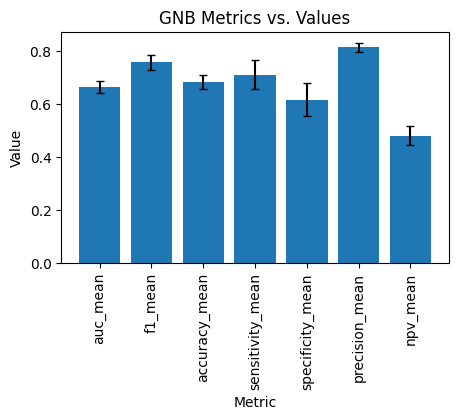

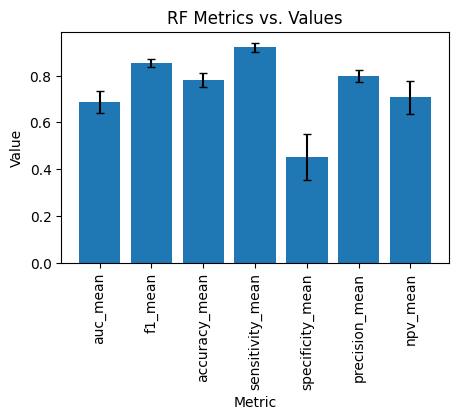

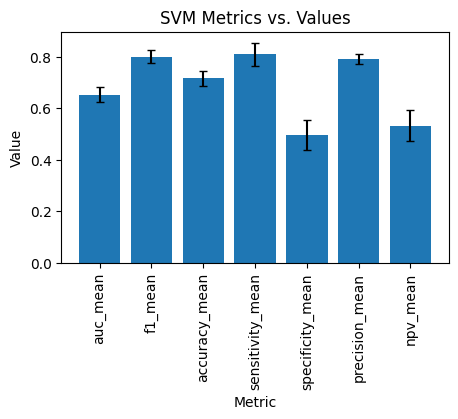

In [19]:
# 6.2
# print(gnb_cross_results)
# print(rf_cross_results)
# print(svm_cross_results)

def plot_results(cross_results, model_type_string):  

    results_columns = []
    results_std = []
    results_columns_values = []
    results_std_values = []

    for column, score in cross_results.items():
        if 'confusion' in column:
            pass
        elif 'mean' in column:
            results_columns.append(column)
            results_columns_values.append(score)
        else:
            results_std.append(column)
            results_std_values.append(score)

    # print(results_columns)
    # print(results_std)
    # print(results_columns_values)
    # print(results_std_values)

    plt.figure(figsize = (5,3))
    plt.bar(results_columns, results_columns_values, yerr = results_std_values, capsize = 3)
    plt.xticks(rotation=90)
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title(f"{model_type_string} Metrics vs. Values")
    plt.show()

plot_results(gnb_cross_results, 'GNB')
plot_results(rf_cross_results, 'RF')
plot_results(svm_cross_results, 'SVM')

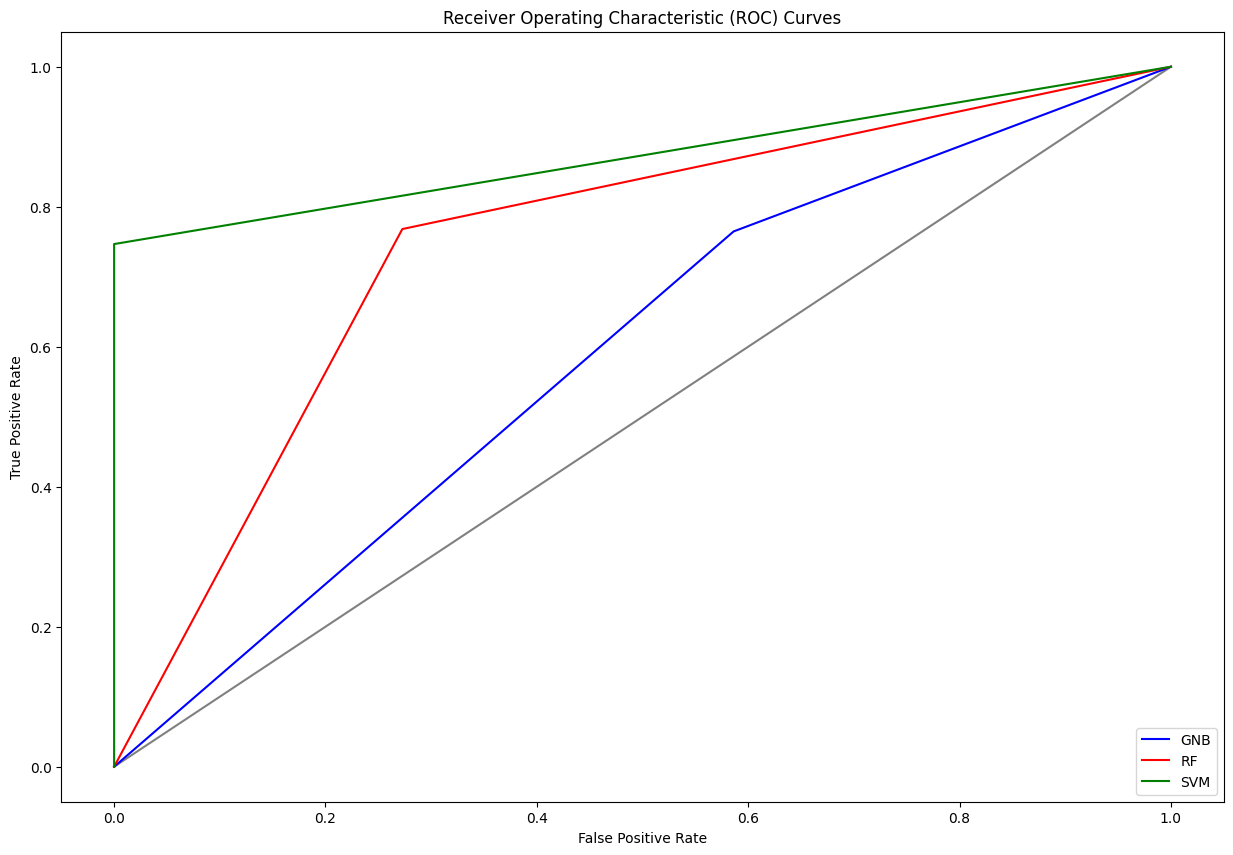

In [20]:
# 6.3

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(15, 10))
plt.plot([0, 1], [0, 1], color='gray')

def plot_roc(y_pred, y_true, color, label):
    
    false_positive_rate, true_positive_rate, _ = roc_curve(y_pred, y_true)
    plt.plot(false_positive_rate, true_positive_rate, color=color, label=f"{label}")


plot_roc(gnb_y_pred, gnb_y_true, 'b', 'GNB')
plot_roc(rf_y_pred, rf_y_true, 'r', 'RF')
plot_roc(svm_y_pred, svm_y_true, 'g', 'SVM')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

6.4

the bar charts are most helpful for me to visualize the differences

the GNB has relatively high specificity,which means it is relatively strong at correctly classifying negatives and avoiding false positives

the RF has relatively high sensitivity, which means it is relatively strong at correctly classifying positives and avoiding false negatives

the SVM is not relatively strong in classifying any class, and based on the confusion matrix, classifies nearly all cases as positive

## Part 7: Holdout Set Evaluation (Instructor)

Your final models `gnb_final`, `svm_final`, and `rf_final` will be evaluated on a holdout set by the instructor.